In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import seaborn as sns
import json
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import gc
from tqdm.notebook import tqdm as tqdm

In [15]:
with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']

large_face_path = '../../DeepFake/large_faces_2/'

In [16]:
# Get all test videos
filenames = []
for filename in Path(video_path).rglob('*.mp4'):
    filenames.append(filename)
print(len(filenames))

119146


In [17]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df.head()

,index,label,split,isVal,cv_fold,person_count,original,version
0,gmuagvvcen.mp4,FAKE,2nd_level,True,4,1,xyioxposka.mp4,2020-01-30
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,acguxjvmju.mp4,2020-01-30
2,smptxlklxc.mp4,REAL,2nd_level,True,2,1,NaN,2020-01-30
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,ptpwappdyx.mp4,2020-01-30
4,hvxrsfgvyi.mp4,FAKE,2nd_level,True,999,2,qelncdmypn.mp4,2020-01-30


In [18]:
df_originals = df[df['original'].isnull()]

In [19]:
def getFilepath(fn):
    for f in filenames:
        if fn in str(f):
            return str(f)
    return None

def getFaceImageReplicatesForOriginalVideo(original_sample, image_dir, n_frames=17):
    original_id = original_sample.replace('.mp4','')
    fake_samples = df[df['original'] == original_sample]['index'].values
    first_person_replicates = []
    second_person_replicates = []
    
    for frame in range(n_frames):
        # first person
        if os.path.isfile(os.path.join(image_dir, original_id + '_0_' + str(frame) + '.png')):
            face_paths = [os.path.join(image_dir, original_id + '_0_' + str(frame) + '.png')]
            for fake in fake_samples:
                fake_id = fake.replace('.mp4','')
                face_paths.append(os.path.join(image_dir, fake_id + '_0_' + str(frame) + '.png'))
            first_person_replicates.append(face_paths)
            
        # second person
        if os.path.isfile(os.path.join(image_dir, original_id + '_1_' + str(frame) + '.png')):
            face_paths = [os.path.join(image_dir, original_id + '_1_' + str(frame) + '.png')]
            for fake in fake_samples:
                fake_id = fake.replace('.mp4','')
                face_paths.append(os.path.join(image_dir, fake_id + '_1_' + str(frame) + '.png'))
            second_person_replicates.append(face_paths)
    return first_person_replicates, second_person_replicates

In [20]:
original_sample = df_originals.iloc[23]['index']
first_person_replicates, second_person_replicates = getFaceImageReplicatesForOriginalVideo(original_sample, large_face_path)
#print(first_person_replicates, second_person_replicates)

In [21]:
def getImagesFromPaths(nested_path_list):
    frames_img_list = []
    for frame_paths in nested_path_list:
        replicate_images = []
        for replicate in frame_paths:
            replicate_images.append(cv2.cvtColor(cv2.imread(replicate),cv2.COLOR_BGR2GRAY))
        frames_img_list.append(replicate_images)
    return frames_img_list

In [22]:
first_person_images = getImagesFromPaths(first_person_replicates)

In [23]:
from skimage.measure import compare_ssim
import warnings

def structural_dissimilarity(grayA, grayB):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        (score, diff) = compare_ssim(grayA, grayB, full=True)
    return (score, diff)

In [24]:
def makeMask(grayImg, th = 0.9):
    #mask = np.where(grayImg < th, 255, 0).astype(np.uint8)
    mask = (255-grayImg*255).astype(np.uint8)
    return mask

In [25]:
def visualizeReplicates(list_of_replicates):
    """First of the replicates is the original"""
    fontsize=16
    f,ax=plt.subplots(3,len(list_of_replicates),figsize=(len(list_of_replicates)*3,3*3))
    for i,img in enumerate(list_of_replicates):
        ax[0,i].imshow(img,cmap='gray')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title('Original' if i==0 else 'Fake-{0}'.format(i))
        score,diff=structural_dissimilarity(list_of_replicates[0],img)
        ax[1,i].imshow(diff, cmap='gray')
        ax[1,i].set_title('Similarity: {0:.3f}'.format(score))
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        mask = makeMask(diff)
        ax[2,i].imshow(mask, cmap='gray')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
    ax[0,0].set_ylabel('Frames', fontsize=fontsize)
    ax[1,0].set_ylabel('Structurral diff.', fontsize=fontsize)
    ax[2,0].set_ylabel('Diff. Mask', fontsize=fontsize)

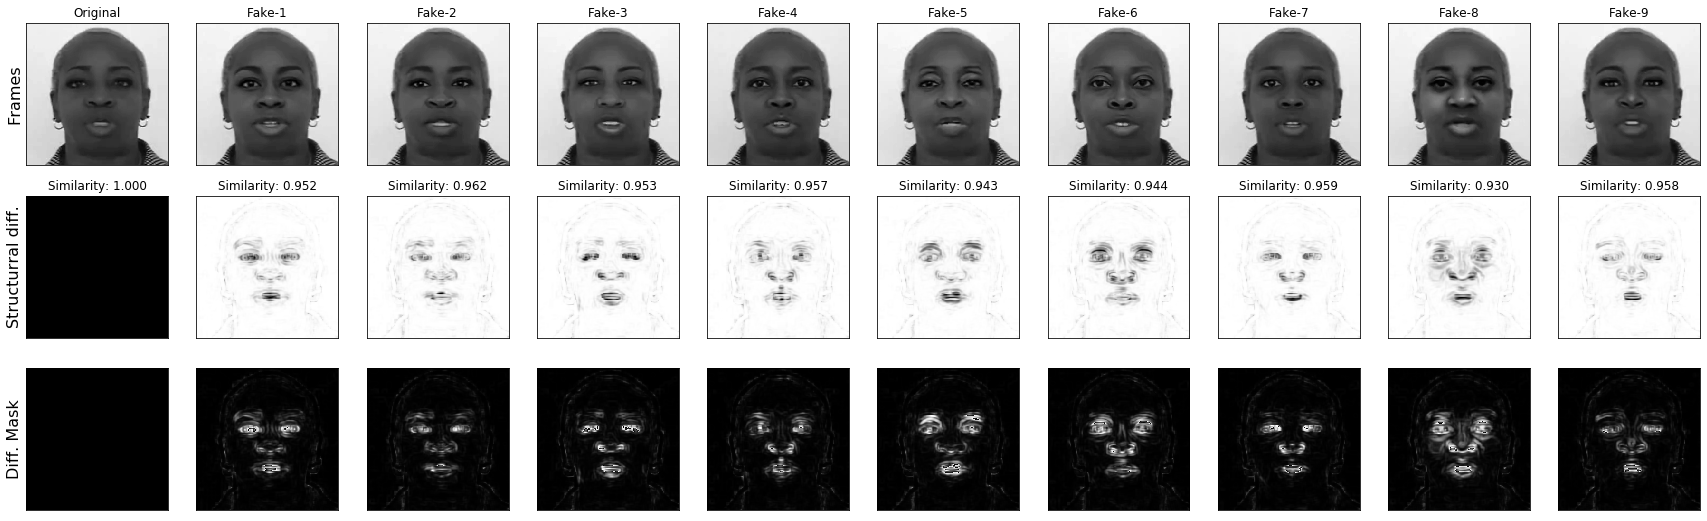

In [26]:
visualizeReplicates(first_person_images[0])

### Time

In [27]:
%%timeit
structural_dissimilarity(first_person_images[0][0],first_person_images[0][1])

7.7 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Create masks from large faces

In [28]:
df_diff = pd.DataFrame({'index':df['index'].values, 'original':df.original.values}).set_index('index')
df_diff['first_person_similarities']=None
df_diff['second_person_similarities']=None
df_diff.head()

,original,first_person_similarities,second_person_similarities
index,,,
gmuagvvcen.mp4,xyioxposka.mp4,None,None
nlbejgudfx.mp4,acguxjvmju.mp4,None,None
smptxlklxc.mp4,NaN,None,None
xmodyeeaxr.mp4,ptpwappdyx.mp4,None,None
hvxrsfgvyi.mp4,qelncdmypn.mp4,None,None


In [29]:
def extractIndexFromPath(pth):
    name = pth.split('/')[-1]
    name = name.split('_')[0]
    name += '.mp4'
    return name

In [30]:
failedFiles = []
for i, file in tqdm(enumerate(df_originals['index'].values), total=len(df_originals)):
    try:
        first_person_replicates, second_person_replicates = getFaceImageReplicatesForOriginalVideo(file, large_face_path)
        first_person_imgs = getImagesFromPaths(first_person_replicates)
        second_person_imgs = getImagesFromPaths(second_person_replicates)

        first_p_scores, second_p_scores = [],[]
        if len(first_person_replicates)>0:
            first_p_scores = np.zeros((len(first_person_replicates),len(first_person_replicates[0])),dtype=np.float)
        if len(second_person_replicates)>0:
            second_p_scores = np.zeros((len(second_person_replicates),len(second_person_replicates[0])),dtype=np.float)

        for frame in range(len(first_person_replicates)):
            for replicate in range(len(first_person_imgs[frame])):
                score,diff=structural_dissimilarity(first_person_imgs[frame][0],first_person_imgs[frame][replicate])
                first_p_scores[frame,replicate] = score
                mask = makeMask(diff)
                mask_path = str(first_person_replicates[frame][replicate]).replace('.png','.jpg')
                cv2.imwrite(mask_path,mask)
                #np.save(mask_path,mask)

        for frame in range(len(second_person_replicates)):
            for replicate in range(len(second_person_imgs[frame])):
                score,diff=structural_dissimilarity(second_person_imgs[frame][0],second_person_imgs[frame][replicate])
                second_p_scores[frame,replicate] = score
                mask = makeMask(diff)
                mask_path = str(second_person_replicates[frame][replicate]).replace('.png','.jpg')
                cv2.imwrite(mask_path,mask)
                #np.save(mask_path,mask)

        # extract df indices from file paths
        if len(first_person_replicates)>0:
            replicate_paths = first_person_replicates[0]
            replicate_indices = [extractIndexFromPath(pth) for pth in replicate_paths]
            for rep in range(len(replicate_indices)):
                df_diff.at[replicate_indices[rep],'first_person_similarities'] = first_p_scores[:,rep]
            if len(second_person_replicates)>0:
                for rep in range(len(replicate_indices)):
                    df_diff.at[replicate_indices[rep],'second_person_similarities'] = second_p_scores[:,rep]
    except:
        failedFiles.append(file)
        print("Exception with " + file)

Exception with esarxzzvkx.mp4
Exception with fwngrtvaee.mp4
Exception with tupereyivk.mp4
Exception with fgasybrtob.mp4
Exception with pnyvxscgpl.mp4
Exception with uvyxhwohay.mp4
Exception with hkbkvhcynv.mp4
Exception with ekbylzhjgp.mp4
Exception with kdxjncawfy.mp4
Exception with sudhffrwig.mp4
Exception with ampuawncsg.mp4
Exception with xltllxrdfg.mp4
Exception with xmmoixcdre.mp4
Exception with eswsjbajnw.mp4
Exception with paupkdijut.mp4
Exception with ragjclplkx.mp4
Exception with aoeuvrhatp.mp4
Exception with suybcasguz.mp4
Exception with wmbsdtznii.mp4
Exception with mwoeriylvo.mp4
Exception with zlnofgtmzv.mp4
Exception with guecziuobg.mp4
Exception with skmatemtcj.mp4
Exception with rujvxjnuya.mp4
Exception with tvzpuvfhxk.mp4
Exception with zpkdvksplv.mp4
Exception with usgjegmdgr.mp4
Exception with wqgiqcujfj.mp4
Exception with jrpkyoteas.mp4
Exception with choscqlfdf.mp4
Exception with txtzdfwgvx.mp4
Exception with jntlukilia.mp4
Exception with fkfqwwralq.mp4
Exception 

In [31]:
df_diff = df_diff.reset_index()
df_diff.to_csv('../data/frame_diff.csv',index=False)

In [32]:
df_diff.head()

,index,original,first_person_similarities,second_person_similarities
0,gmuagvvcen.mp4,xyioxposka.mp4,"[0.9066220547557992, 0.9145454353513006, 0.908...",None
1,nlbejgudfx.mp4,acguxjvmju.mp4,"[0.8767046332818267, 0.8788463821382078, 0.881...",None
2,smptxlklxc.mp4,NaN,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",None
3,xmodyeeaxr.mp4,ptpwappdyx.mp4,"[0.9676854402403808, 0.9703408963580981, 0.965...",None
4,hvxrsfgvyi.mp4,qelncdmypn.mp4,"[0.9324553186865269, 0.9324183775018723, 0.930...","[0.9692700678378317, 0.9687523008252776, 0.970..."
